# A1 assignment's notebook for Complex Networks at URV 2025

## Authors:

Lobo Santos, Antonio
Kasa, Andrar

 ## Requirements and Constants
 This cell imports all the necessary libraries for data handling, numerical operations, plotting, and network analysis. 
 It also sets up important constant like Dataset Path.


In [8]:
# Requirements
import pandas as pd          # For dataframes and analysis
import numpy as np           # For numerical operations
import matplotlib.pyplot as plt  # For plotting
from matplotlib import rcParams
from matplotlib import colors
import random as random      # For randomness if needed
import networkx as nx        # For network tools
import os                    # For file management

DATASET_PATH = os.path.join("..","Datasets") # Path to the datasets folder

### Reading a Pajek (.net) File 
This cell defines a function `read_network` which takes a filepath to a Pajek file (with extension `.net`) and returns a NetworkX graph. Internally, it uses `nx.read_pajek` to read the network and then converts it to a simple `nx.Graph` (if the network is undirected)

In [3]:
def read_network(filepath):
    """
    Reads a network stored in Pajek (.net) format and returns a NetworkX graph.
    
    Parameters:
        filepath (str): Path to the .net file.
        
    Returns:
        G (nx.Graph or nx.DiGraph): The resulting network.
    """
    # Read the network using NetworkX's read_pajek function
    G = nx.read_pajek(filepath)
    
    # Optionally, convert to a simple Graph if you want to ignore parallel edges or self-loops.
    if G.is_directed():
        G = nx.DiGraph(G)
    else:
        G = nx.Graph(G)
        
    return G

# # Example usage:
# G = read_network("Datasets/net1.net")


# Part 1: Structural characterization of networks

## Macroscopic Analysis

### Computing Network Metrics 
This cell defines a function `compute_network_metrics` that computes key macroscopic metrics of the network: - Number of nodes and edges - Minimum, maximum, and average degree - Average clustering coefficient - Degree assortativity coefficient - Average path length and network diameter (computed on the largest connected component if the graph is not connected) The results are returned as a pandas DataFrame.

In [4]:
def compute_network_metrics(G, graph_name):
    """
    Computes several network metrics and returns them in a pandas DataFrame.
    
    Metrics computed:
      - Number of nodes
      - Number of edges
      - Minimum degree, maximum degree, and average degree
      - Average clustering coefficient
      - Degree assortativity
      - Average path length (for largest connected component if the network is not connected)
      - Diameter (for largest connected component if the network is not connected)
    
    Parameters:
        G (nx.Graph or nx.DiGraph): The networkx graph.
        graph_name (str): The name of the graph to use as the index for the DataFrame.
        
    Returns:
        metrics_df (pd.DataFrame): DataFrame with the computed metrics.
    """
    # Basic metrics
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    degrees = [d for n, d in G.degree()]
    min_degree = np.min(degrees)
    max_degree = np.max(degrees)
    avg_degree = np.mean(degrees)
    
    # Average clustering coefficient
    avg_clustering = nx.average_clustering(G)
    
    # Degree assortativity
    assortativity = nx.degree_assortativity_coefficient(G)
    
    # For metrics that require connectivity (average path length and diameter),
    # we use the largest connected component if G is not connected.
    if nx.is_connected(G):
        avg_path_length = nx.average_shortest_path_length(G)
        diameter = nx.diameter(G)
    else:
        # Get the largest connected component
        largest_cc = max(nx.connected_components(G), key=len)
        subgraph = G.subgraph(largest_cc)
        avg_path_length = nx.average_shortest_path_length(subgraph)
        diameter = nx.diameter(subgraph)
    
    # Compile the metrics into a dictionary
    metrics = {
        "Number of Nodes": [num_nodes],
        "Number of Edges": [num_edges],
        "Min Degree": [min_degree],
        "Max Degree": [max_degree],
        "Average Degree": [avg_degree],
        "Average Clustering Coefficient": [avg_clustering],
        "Degree Assortativity": [assortativity],
        "Average Path Length": [avg_path_length],
        "Diameter": [diameter]
    }
    
    # Create a DataFrame from the dictionary and set the index to the provided graph name
    metrics_df = pd.DataFrame(metrics, index=[graph_name])
    
    return metrics_df

# # Example usage:
# metrics_df = compute_network_metrics(G, "network 1")
# metrics_df


### Plotting Degree Distribution Histograms 
This function, `plot_degree_distributions`, accepts a parameter `plot_type` that determines the visualization mode: - **'both'**: Displays a single figure with two subplots—one for the linear histogram and one for the log-log histogram. - **'linear'**: Displays only the linear scale histogram in a larger, standalone plot. - **'loglog'**: Displays only the log-log histogram in a larger, standalone plot. This flexibility allows the user to choose between a combined view or a more detailed focus on one of the visualizations.
Based on both visualizations authors decide a specific one for each of the networks provided.

In [5]:
def plot_degree_distributions(G, plot_type='both'):
    """
    Plots the degree distribution of a network based on the selected visualization mode.
    
    Parameters:
        G (nx.Graph or nx.DiGraph): The networkx graph.
        plot_type (str): Visualization mode, with three options:
                         'both'   -> Plot both the linear and log-log histograms side by side.
                         'linear' -> Plot only the linear histogram in a standalone, larger plot.
                         'loglog' -> Plot only the log-log histogram in a standalone, larger plot.
                         Default is 'both'.
    """
    # Get the degree of each node
    degrees = [d for n, d in G.degree()]
    
    # Define bins for the linear histogram
    linear_bins = range(min(degrees), max(degrees) + 2)
    
    # Define logarithmic bins for the log-log histogram
    # Ensure we start at 1 to avoid log(0)
    log_bins = np.logspace(np.log10(max(min(degrees), 1)), np.log10(max(degrees)), num=20)
    
    if plot_type == 'both':
        # Create a figure with two subplots side by side
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # Linear scale histogram
        axes[0].hist(degrees, bins=linear_bins, edgecolor='black')
        axes[0].set_title("Degree Distribution (Linear Scale)")
        axes[0].set_xlabel("Degree")
        axes[0].set_ylabel("Frequency")
        
        # Log-log histogram with logarithmic bins
        axes[1].hist(degrees, bins=log_bins, edgecolor='black')
        axes[1].set_xscale("log")
        axes[1].set_yscale("log")
        axes[1].set_title("Degree Distribution (Log-Log Scale)")
        axes[1].set_xlabel("Degree")
        axes[1].set_ylabel("Frequency")
        
        plt.tight_layout()
        plt.show()
        
    elif plot_type == 'linear':
        # Create a larger standalone plot for the linear histogram
        plt.figure(figsize=(8, 6))
        plt.hist(degrees, bins=linear_bins, edgecolor='black')
        plt.title("Detailed Degree Distribution (Linear Scale)")
        plt.xlabel("Degree")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()
        
    elif plot_type == 'loglog':
        # Create a larger standalone plot for the log-log histogram
        plt.figure(figsize=(8, 6))
        plt.hist(degrees, bins=log_bins, edgecolor='black')
        plt.xscale("log")
        plt.yscale("log")
        plt.title("Detailed Degree Distribution (Log-Log Scale)")
        plt.xlabel("Degree")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()
        
    else:
        raise ValueError("Invalid plot_type. Choose 'both', 'linear', or 'loglog'.")

# # Example usage:
# # For both histograms in one figure:
# plot_degree_distributions(G, plot_type='both')
# #
# # For a larger linear histogram:
# plot_degree_distributions(G, plot_type='linear')
# #
# # For a larger log-log histogram:
# plot_degree_distributions(G, plot_type='loglog')


### Putting Everything Together:
In this section we will use previously defined functions to obtain and interpret the results of network 1 to 4.
With this purpose we create a function `analyze_network_macroscopic` that receives a name and computes and print all the macroscopic metrics.
These results will be discussed in `Assignment1_report.pdf`

In [13]:
def analyze_network_macroscopic(filepath, graph_name):
    """
    Analyzes the macroscopic properties of a network by reading the network,
    computing metrics, and plotting degree distribution histograms.
    
    Parameters:
        filepath (str): Path to the .net file.
        graph_name (str): The name of the graph to use for labeling.
        
    Returns:
        metrics_df (pd.DataFrame): DataFrame with the computed metrics.
    """
    # Read the network
    G = read_network(filepath)
    
    # Compute network metrics
    metrics_df = compute_network_metrics(G, graph_name)
    print(metrics_df)
    
    # Plot degree distributions
    plot_degree_distributions(G, plot_type='both')
    
    return metrics_df

# Example usage:
# metrics_df = analyze_network_macroscopic("Datasets/net1.net", "network 1")

#### Network 1:

           Number of Nodes  Number of Edges  Min Degree  Max Degree  \
network 1             5000            25000           6          16   

           Average Degree  Average Clustering Coefficient  \
network 1            10.0                         0.41407   

           Degree Assortativity  Average Path Length  Diameter  
network 1             -0.009733             5.121125         8  


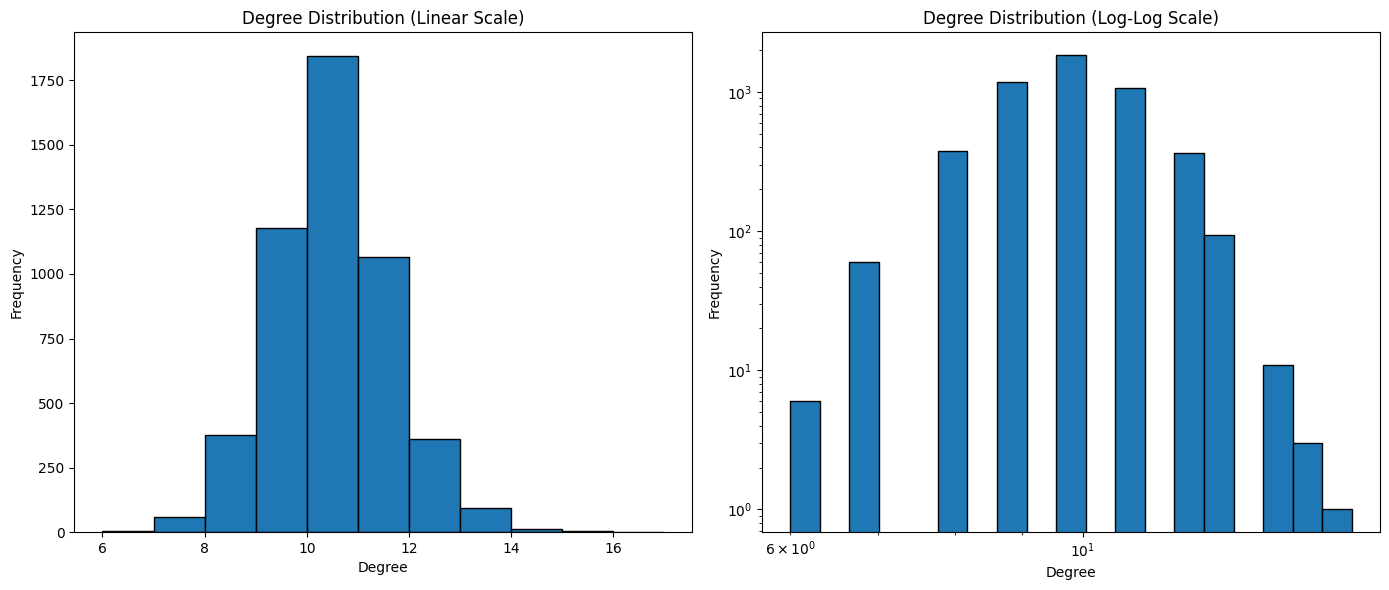

,Number of Nodes,Number of Edges,Min Degree,Max Degree,Average Degree,Average Clustering Coefficient,Degree Assortativity,Average Path Length,Diameter
network 1,5000,25000,6,16,10.0,0.41407,-0.009733,5.121125,8


In [14]:
metrics_df = analyze_network_macroscopic("Datasets/net1.net", "network 1")
metrics_df

#### Network 2:

           Number of Nodes  Number of Edges  Min Degree  Max Degree  \
network 2             5000            24873           1          24   

           Average Degree  Average Clustering Coefficient  \
network 2          9.9492                        0.002099   

           Degree Assortativity  Average Path Length  Diameter  
network 2             -0.005663              3.95605         7  


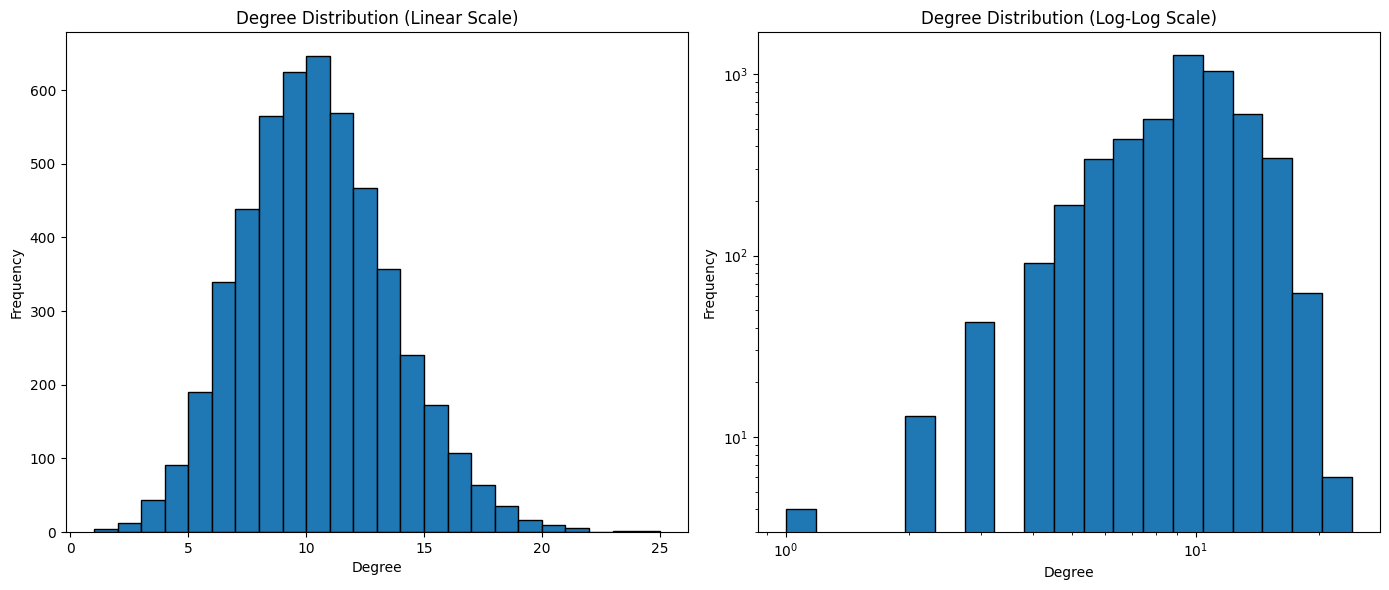

,Number of Nodes,Number of Edges,Min Degree,Max Degree,Average Degree,Average Clustering Coefficient,Degree Assortativity,Average Path Length,Diameter
network 2,5000,24873,1,24,9.9492,0.002099,-0.005663,3.95605,7


In [15]:
metrics_df = analyze_network_macroscopic("Datasets/net2.net", "network 2")
metrics_df

#### Network 3:

           Number of Nodes  Number of Edges  Min Degree  Max Degree  \
network 3             5000            23508           3         732   

           Average Degree  Average Clustering Coefficient  \
network 3          9.4032                        0.086214   

           Degree Assortativity  Average Path Length  Diameter  
network 3              -0.13386             3.008243         5  


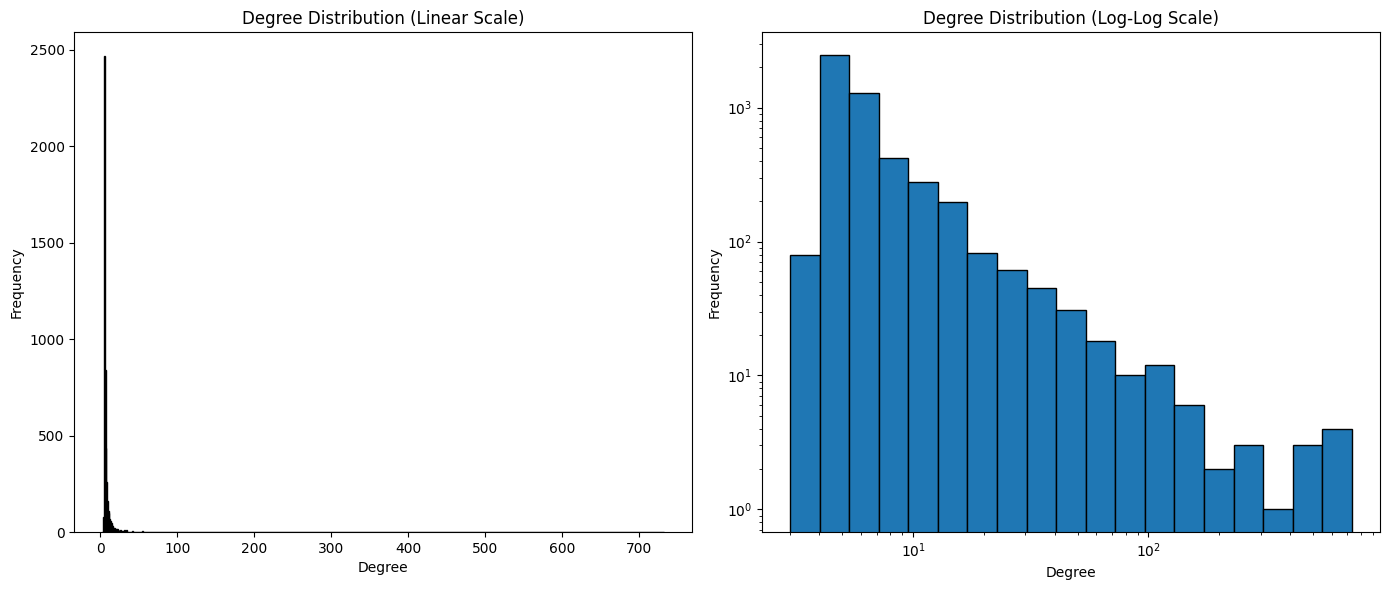

,Number of Nodes,Number of Edges,Min Degree,Max Degree,Average Degree,Average Clustering Coefficient,Degree Assortativity,Average Path Length,Diameter
network 3,5000,23508,3,732,9.4032,0.086214,-0.13386,3.008243,5


In [16]:
metrics_df = analyze_network_macroscopic("Datasets/net3.net", "network 3")
metrics_df

#### Network 4:

           Number of Nodes  Number of Edges  Min Degree  Max Degree  \
network 4             5000            24975           5         210   

           Average Degree  Average Clustering Coefficient  \
network 4            9.99                        0.010729   

           Degree Assortativity  Average Path Length  Diameter  
network 4             -0.032451             3.486817         5  


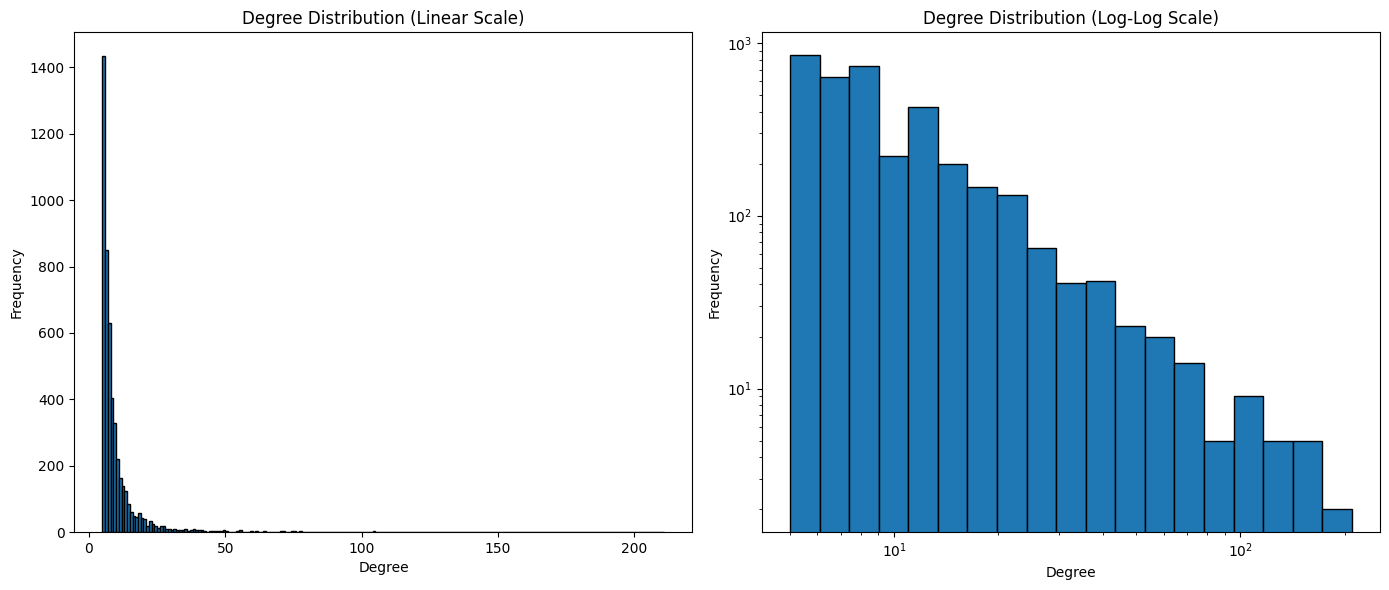

,Number of Nodes,Number of Edges,Min Degree,Max Degree,Average Degree,Average Clustering Coefficient,Degree Assortativity,Average Path Length,Diameter
network 4,5000,24975,5,210,9.99,0.010729,-0.032451,3.486817,5


In [17]:
metrics_df = analyze_network_macroscopic("Datasets/net4.net", "network 4")
metrics_df

## Microscopic Analysis

### Computing Node Centralities
This cell defines a function `compute_centrality_measures` which calculates different centrality measures using built-in NetworkX functions: - PageRank - Eigenvector Centrality - Betweenness Centrality - Closeness Centrality The function then identifies the top 5 nodes for each centrality metric and prints the results.

In [11]:
def compute_centrality_measures(G):
    """
    Computes several node centralities and prints the top 5 nodes for each metric.
    
    Centrality metrics computed:
      - PageRank
      - Eigenvector Centrality
      - Betweenness Centrality
      - Closeness Centrality
      
    Parameters:
        G (nx.Graph or nx.DiGraph): The networkx graph.
        
    Returns:
        centralities (dict): Dictionary containing centrality dictionaries for each metric.
    """
    # Compute centralities using pre-built functions in networkx
    page_rank = nx.pagerank(G)
    eigenvector = nx.eigenvector_centrality(G, max_iter=1000)
    betweenness = nx.betweenness_centrality(G)
    closeness = nx.closeness_centrality(G)
    
    centralities = {
        "PageRank": page_rank,
        "Eigenvector": eigenvector,
        "Betweenness": betweenness,
        "Closeness": closeness
    }
    
    # Function to get top 5 nodes sorted by centrality score
    def top_n(centrality_dict, n=5):
        return sorted(centrality_dict.items(), key=lambda item: item[1], reverse=True)[:n]
    
    print("Top 5 nodes by PageRank:")
    print(top_n(page_rank))
    print("\nTop 5 nodes by Eigenvector Centrality:")
    print(top_n(eigenvector))
    print("\nTop 5 nodes by Betweenness Centrality:")
    print(top_n(betweenness))
    print("\nTop 5 nodes by Closeness Centrality:")
    print(top_n(closeness))
    
    return centralities

# Example usage:
centrality_measures = compute_centrality_measures(G)


Top 5 nodes by PageRank:
[('1693', 0.00030175487047756096), ('1579', 0.00028388678447130244), ('4891', 0.00028220471889688444), ('651', 0.0002781650719532121), ('3659', 0.00027272325685037885)]

Top 5 nodes by Eigenvector Centrality:
[('651', 0.028633763508762854), ('1937', 0.026474594033319834), ('4526', 0.02563343180801723), ('4398', 0.025252835330342085), ('1939', 0.025168617334937908)]

Top 5 nodes by Betweenness Centrality:
[('4747', 0.004055369557376794), ('2645', 0.004047284753591308), ('230', 0.0038027851775868458), ('4360', 0.0037945536735594465), ('1579', 0.003655219224457124)]

Top 5 nodes by Closeness Centrality:
[('1579', 0.2170835504603092), ('807', 0.21535346573040967), ('4339', 0.2150847603476465), ('4747', 0.2150662536568577), ('757', 0.21501075268817205)]


# Part 2: Models

### Model Verification


In this part we compute extra metrics to prove the models that we have hypothesized based on the previous analysis.

#### Network 1


#### Network 2


#### Network 3


#### Network 4


## Network 5 Visualization

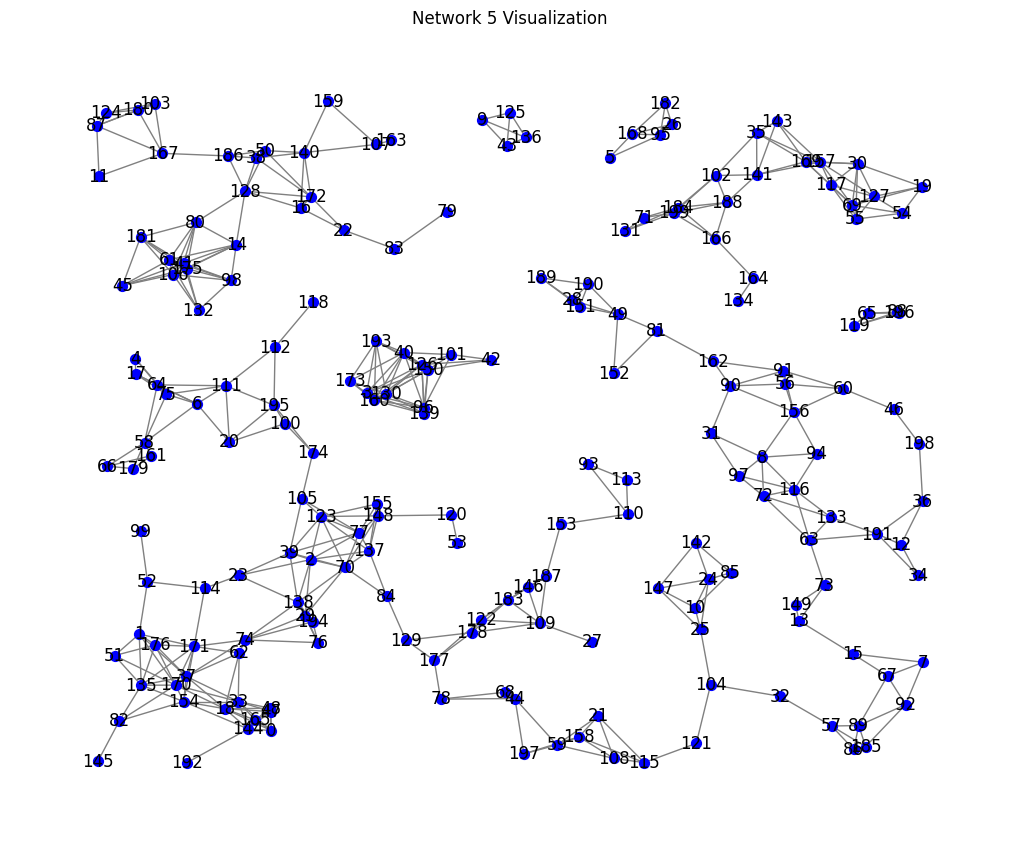

In [12]:
# Read the network
network_path = os.path.join(DATASET_PATH, "net5.net")
G_net5 = read_network(network_path)

# Read the positions from the file
positions_net5 = {}
positions_net5_path = os.path.join(DATASET_PATH, "positions_net5.txt")
with open(positions_net5_path, "r") as f:
    next(f)  # Skip the first line (header)
    for line in f:
        node, x, y = line.strip().split()
        positions_net5[node] = (float(x), float(y))

# Plot the network
plt.figure(figsize=(10, 8))
nx.draw(G_net5, pos=positions_net5, with_labels=True, node_size=50, node_color='blue', edge_color='gray')
plt.title("Network 5 Visualization")
plt.show()